# SETUP

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
import geopandas as gpd
import xarray as xr
import rioxarray
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import matplotlib as mpl
import cartopy.feature as cf
import regionmask
var = 'mcwd'
shp_pan = gpd.read_file(r'Data\shapefiles\panamz.geojson')
folder_metric = rf'Data\Datasets\amz\{var}'
datasets = ['cru', 'gpcc', 'chirps','imerg', 'terra', 'era_land', 'jra55','merra2']
datasets_names = ['CRU', 'GPCC', 'CHIRPS','IMERG-V6', 'TerraClimate', 'ERA5-Land', 'JRA55','MERRA2']
stations = gpd.read_file(rf'Data\Datasets\amz\{var}\stations.geojson')
regions = gpd.read_file(r'Data\shapefiles\ANA_amz.geojson', driver='GeoJSON')
regions_mask = regionmask.from_geopandas(regions, names='Region')
df_stat = pd.read_csv(rf'Data\Datasets\amz\{var}\stations_ts.csv', index_col=0)


In [2]:
from matplotlib.lines import Line2D
plt.rcParams.update({'font.size': 18})
regions_list = ['Western', 'Northern', 'Southern', 'Eastern']
regions_replace = { 0:'Southern', 1:'Eastern',2:'Western', 3:'Northern'}
wong = ['#882255','#E69F00','#56B4E9','#009E73','#F0E442','#0072B2','#D55E00','#CC79A7','#999999']
wong_b = ['#882255','#E69F00','#56B4E9','#009E73','#F0E442','#0072B2','#D55E00','#CC79A7','#000000']
hue_order = datasets_names.copy()
hue_order.append('Stations')
legend_elements = [Line2D([0], [0],  marker='s', color='w', label=hue_order[i], markerfacecolor=wong[i], markersize=12) for i in range(len(wong))]
legend_elements_b = [Line2D([0], [0],  marker='s', color='w', label=hue_order[i], markerfacecolor=wong_b[i], markersize=12) for i in range(len(wong_b))]


In [3]:
ds_dict = {}
for i, dataset in enumerate(datasets):
    ds = xr.open_dataset(os.path.join(folder_metric, dataset + '.nc'))
    #create mask from regions
    mask = regions_mask.mask(ds, lon_name='lon', lat_name='lat')
    ds['Region'] = mask
    ds_dict[datasets_names[i]] = ds
    

c:\Users\luisg\anaconda3\envs\geo_env\lib\site-packages\pygeos\io.py:518: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  arr[:] = geometry
c:\Users\luisg\anaconda3\envs\geo_env\lib\site-packages\pygeos\io.py:518: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  arr[:] = geometry


In [4]:
df_stat = pd.read_csv(rf'Data\Datasets\amz\{var}\stations_ts.csv', index_col=0)
#merge with stations to get the region
df_stat = df_stat.merge(stations[['Code','geometry']], on='Code')
df_stat = df_stat.rename(columns={'Date':'year'})
import xskillscore as xs
# Step 1: Convert GeoDataFrame to DataFrame with point coordinates, rainfall values, and timestamps
data = df_stat[['geometry', 'year', var]].copy()
data['lon'] = data['geometry'].apply(lambda p: p.x)
data['lat'] = data['geometry'].apply(lambda p: p.y)
data = data.drop(columns=['geometry'])

In [5]:
pixel_dict = {}

for name in datasets_names:
    ds = ds_dict[name].copy()

    # Step 2: Assign each point to the grid cells of the 'ds' DataArray
    ds_grid_lon, ds_grid_lat = ds.lon.values, ds.lat.values

    data['lon_bin'] = np.digitize(data['lon'], ds_grid_lon)
    data['lat_bin'] = np.digitize(data['lat'], ds_grid_lat)

    # Step 3: Compute the mean value for each grid cell and each year
    grid_cells = data.groupby(['year', 'lat_bin', 'lon_bin'])[var].mean().reset_index()

    # Step 4: Create an empty DataArray with NaN values
    empty_grid = np.full((len(data['year'].unique()), len(ds_grid_lat), len(ds_grid_lon)), np.nan)

    # Step 5: Fill the DataArray with the computed mean values for each year
    for _, row in grid_cells.iterrows():
        year_idx = np.where(data['year'].unique() == row['year'])[0][0]
        lat_idx, lon_idx = row['lat_bin'], row['lon_bin']
        lat_idx, lon_idx = int(lat_idx), int(lon_idx)

        empty_grid[year_idx, lat_idx - 1, lon_idx - 1] = row[var]

    # Step 6: Create an xarray DataArray from the result with the year dimension
    year_coords = data['year'].unique()
    data_array = xr.DataArray(empty_grid,
                                dims=('year', 'lat', 'lon'),
                                coords={'year': year_coords, 'lat': ds_grid_lat, 'lon': ds_grid_lon})



    data_array = data_array.to_dataset(name=var)
    data_array['Region'] = ds['Region']
    pixel_dict[name] = ds.where(data_array[var] != np.nan)


In [6]:
df = pd.DataFrame()
for name in datasets_names:
    ds = pixel_dict[name]
    dff =  ds.to_dataframe().dropna().reset_index()
    dff['Dataset'] = name
    df = df.append(dff)
df = df[['year',var, 'Region', 'Dataset']]
df['Region'] = df['Region'].replace(regions_replace)
df_stat = pd.read_csv(rf'Data\Datasets\amz\{var}\stations_ts.csv', index_col=0)
df_stat = df_stat.merge(stations[['Code', 'Region']], on='Code')
df_stat = df_stat.rename(columns={'Date':'year'})
df_stat['Dataset'] = 'Stations'
df = df.append(df_stat[['year',var, 'Region', 'Dataset']])

C:\Users\luisg\AppData\Local\Temp\ipykernel_27108\2683523440.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_27108\2683523440.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_27108\2683523440.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_27108\2683523440.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_27108\2683523440.py:6: FutureWarning: The frame.append method is dep

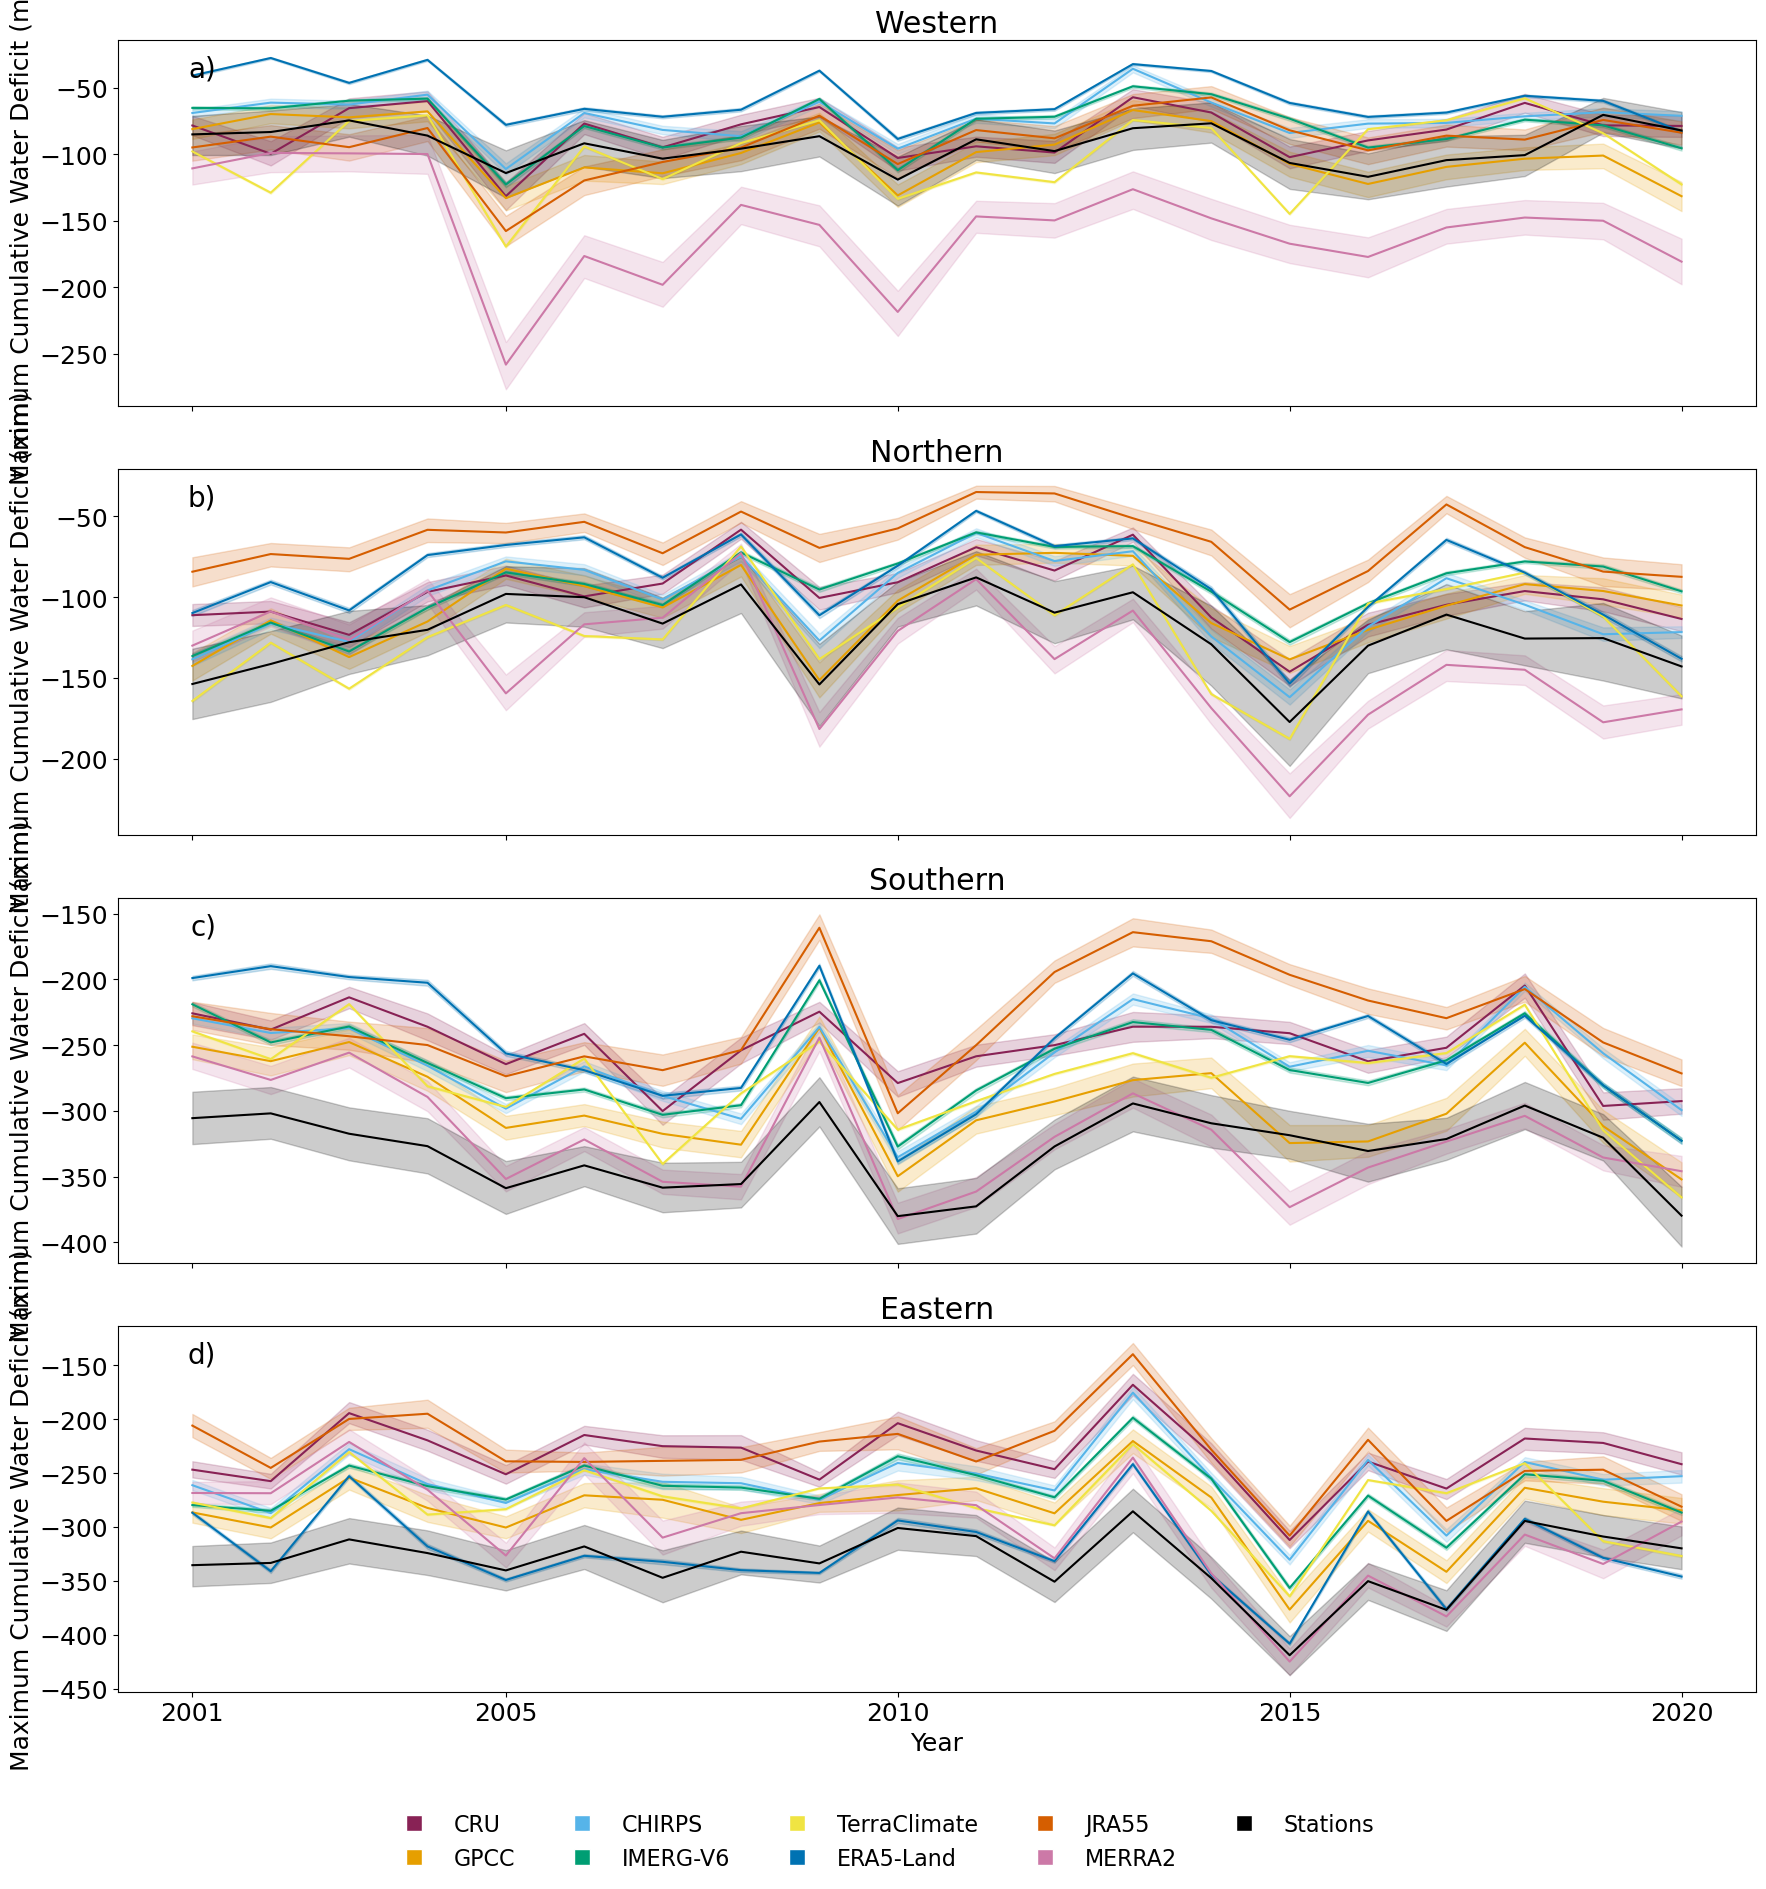

In [7]:
fig, axs = plt.subplots(4, 1, figsize=(18, 18), sharex='col')
plt.rcParams.update({'font.size': 18})
letters_ts = ['a)', 'b)', 'c)', 'd)']
letters_pdf = ['e)', 'f)', 'g)', 'h)']
for i, region in enumerate(regions_list):
    df_region = df[df['Region'] == region]
    sns.lineplot(data=df_region, ax=axs[i], x='year', y=var, hue='Dataset', palette=wong_b, hue_order=hue_order, legend=False)
    #sns.histplot(data=df_region[df_region.Dataset=='Stations'], x=var, fill=False,linewidth=2,color='black', zorder=100,ax=axs[i, 1], legend=False,, stat='density') 
    axs[i].set_title(region)
    axs[i].set_ylabel('Maximum Cumulative Water Deficit (mm)')
    axs[i].set_xlabel('Year')
    axs[i].set_xticks([2001, 2005,2010, 2015, 2020])
    axs[i].text(0.06,0.96,  letters_ts[i], transform=axs[i].transAxes,  fontsize=20, va='top', ha='right')
    #Set axs[i, 1] y-axis as scientific notation
#create legend in the bottom center of the figure
fig.legend(handles=legend_elements_b, bbox_to_anchor=(0.5, -0.06), loc='lower center', ncol=5, frameon=False, fontsize=16)


plt.tight_layout()

In [7]:
from Data.utils.taylor import *
from scipy.stats import pearsonr
df_mean = df.groupby(['year', 'Region', 'Dataset']).mean().reset_index()
#for each dataset and each region, do the pearson r with stations
df_corr = pd.DataFrame()
std_ref = []
for region in regions_list :
    df_region = df_mean[df_mean['Region'] == region]
    df_station = df_region[df_region['Dataset'] == 'Stations']
    for dataset in datasets_names:
        df_ds = df_region[df_region['Dataset'] == dataset]
        # do correlation
        corr = pearsonr(df_ds[var].values, df_station[var].values)[0].round(2)
        df_corr = df_corr.append({'Region': region, 'Dataset': dataset, 'corr': corr, 'sd':df_ds[var].values.std()/df_station[var].values.std()}, ignore_index=True)
        std_ref.append(df_station[var].values.std())
        

C:\Users\luisg\AppData\Local\Temp\ipykernel_27108\1335021774.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_corr = df_corr.append({'Region': region, 'Dataset': dataset, 'corr': corr, 'sd':df_ds[var].values.std()/df_station[var].values.std()}, ignore_index=True)
C:\Users\luisg\AppData\Local\Temp\ipykernel_27108\1335021774.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_corr = df_corr.append({'Region': region, 'Dataset': dataset, 'corr': corr, 'sd':df_ds[var].values.std()/df_station[var].values.std()}, ignore_index=True)
C:\Users\luisg\AppData\Local\Temp\ipykernel_27108\1335021774.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_corr = df_corr.append({'Region': region, 'Dataset': dataset, 'corr': corr,

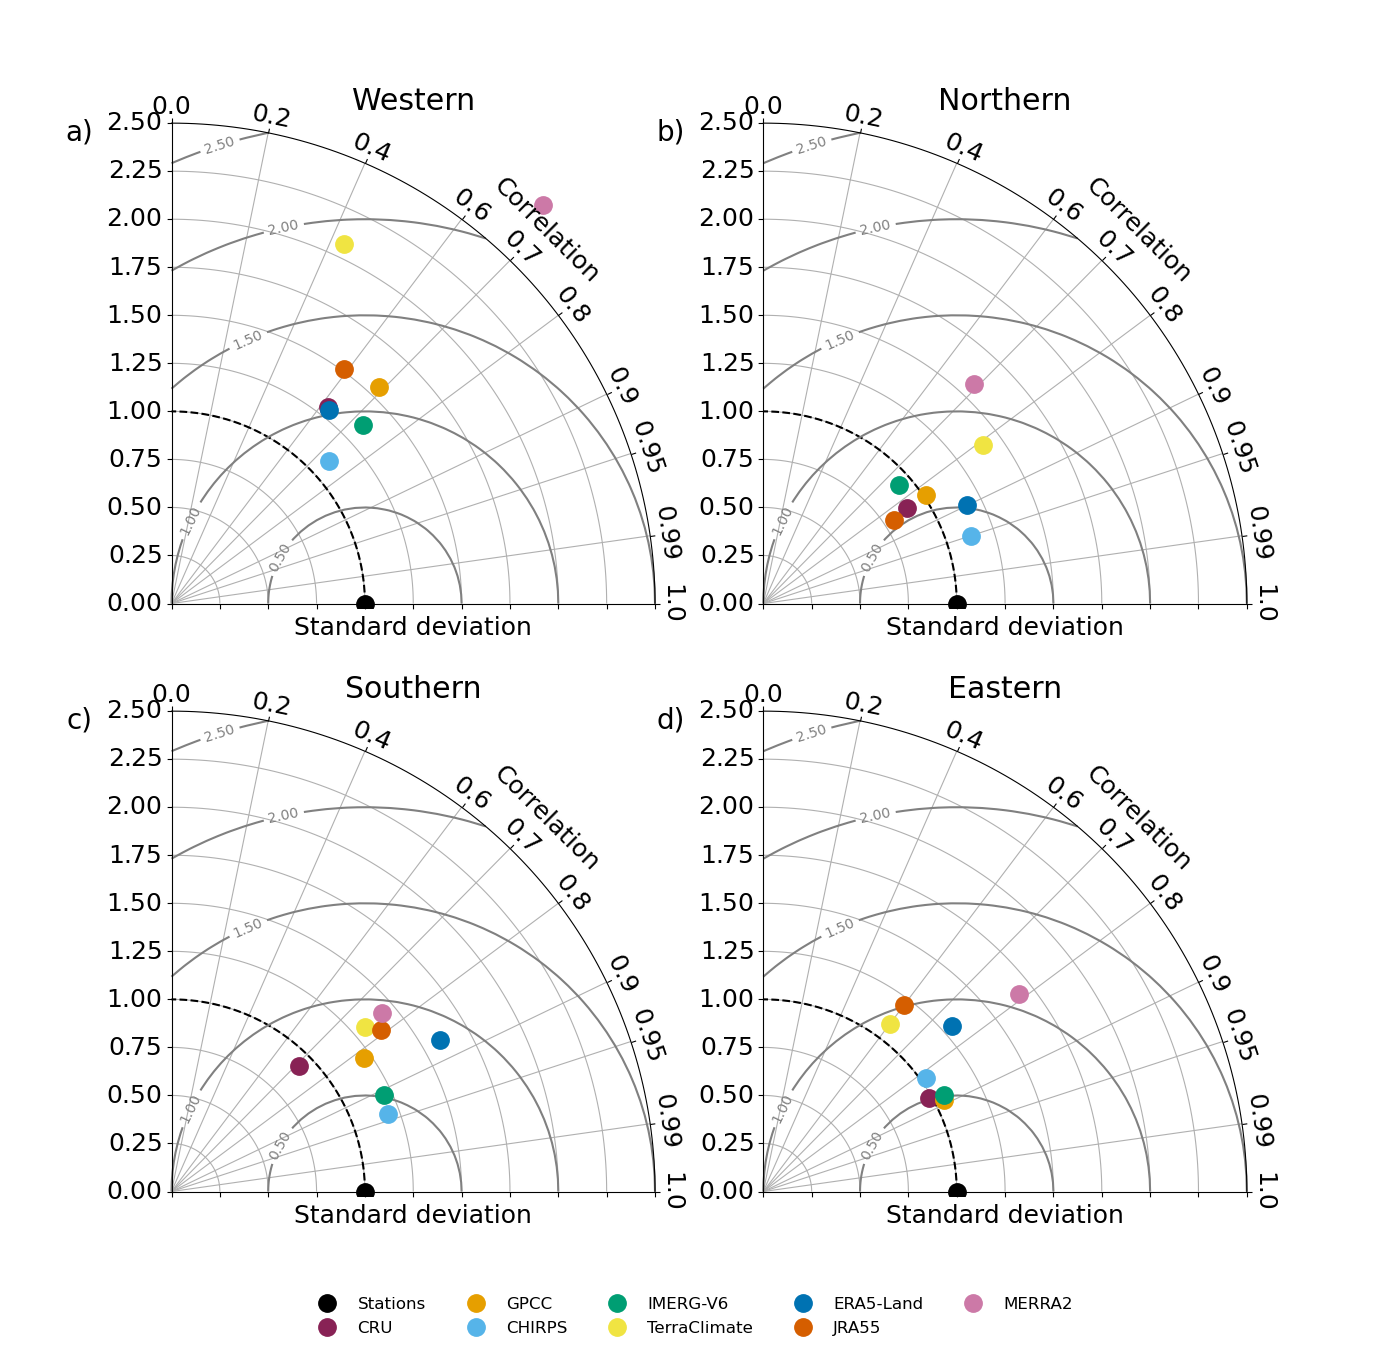

In [8]:
# Create a figure and a gridspec layout
fig = plt.figure(figsize=(14, 14))
letters_ts = ['a)', 'b)', 'c)', 'd)']

mss = 25
for i, region in enumerate(regions_list ):
    dia = TaylorDiagram(1, fig=fig, label='Stations', extend=False, rect=int('22'+str(i+1)),srange=(0, 2.5),mss =mss)
# Create a figure and a gridspec layout

    df_reg = df_corr[df_corr.Region == region]
    # Add samples to Taylor diagram
    contours = dia.add_contours(colors='0.5')
    for j, name in enumerate(datasets_names):
        df_set = df_reg[df_reg['Dataset'] == name]
        std = df_set['sd'].values[0]
        corr = df_set['corr'].values[0]
        dia.add_sample(std, corr, marker='.', ms=mss, ls='', mfc=wong_b[j], mec=wong_b[j], label=name)
    dia.add_grid()                                  # Add grid
    dia._ax.axis[:].major_ticks.set_tick_out(True)
    dia._ax.axis['left'].toggle(ticklabels=False)
    dia._ax.axis['left'].label.set_text("Standard deviation")
    dia._ax.set_title(region)
    dia._ax.text(-0.15,1,  letters_ts[i], transform=dia._ax.transAxes,  fontsize=20, va='top', ha='right')    
    # Put ticks outward
#legend in the middle outside of the plot
    plt.clabel(contours, inline=1, fontsize=10, fmt='%.2f')

fig.legend(dia.samplePoints,
               [ p.get_label() for p in dia.samplePoints ],
               numpoints=1, bbox_to_anchor=(0.5, 0.0), loc='lower center', ncol=5, frameon=False, fontsize=12)

#legend in the middle outside of the plot
plt.tight_layout()

In [9]:
df_corr['metric'] = 'MCWD'
df_corr.to_csv(rf'Data\Datasets\amz\{var}\corr.csv')

# point

In [11]:
var = 'mcwd'
df_stat = pd.read_csv(rf'Data\Datasets\amz\{var}\stations_ts.csv', index_col=0)
#merge with stations to get the region
df_stat = df_stat.merge(stations[['Code','geometry']], on='Code')
df_stat = df_stat.rename(columns={'Date':'year'})
import xskillscore as xs
# Step 1: Convert GeoDataFrame to DataFrame with point coordinates, rainfall values, and timestamps
data = df_stat[['geometry', 'year', var]].copy()
data['lon'] = data['geometry'].apply(lambda p: p.x)
data['lat'] = data['geometry'].apply(lambda p: p.y)
data = data.drop(columns=['geometry'])

from Data.utils.evaluation import calculate_metrics, create_metrics_dataframe,  datasets_05
from Data.utils.datasets_plotting import plot_datasets33_nostat
metrics_dict = calculate_metrics(data, datasets_names, ds_dict, var)
df_metrics = create_metrics_dataframe(metrics_dict, datasets_names)
metrics_dict_05 = datasets_05(metrics_dict, ds_dict, datasets_names)

c:\Users\luisg\anaconda3\envs\geo_env\lib\site-packages\xskillscore\core\np_deterministic.py:258: RuntimeWarning: divide by zero encountered in divide
  r2 = 1 - (num / den)
c:\Users\luisg\anaconda3\envs\geo_env\lib\site-packages\xskillscore\core\np_deterministic.py:258: RuntimeWarning: divide by zero encountered in divide
  r2 = 1 - (num / den)
c:\Users\luisg\anaconda3\envs\geo_env\lib\site-packages\xskillscore\core\np_deterministic.py:258: RuntimeWarning: divide by zero encountered in divide
  r2 = 1 - (num / den)
c:\Users\luisg\anaconda3\envs\geo_env\lib\site-packages\xskillscore\core\np_deterministic.py:258: RuntimeWarning: divide by zero encountered in divide
  r2 = 1 - (num / den)
d:\GU\IC\Scripts\Data\utils\evaluation.py:151: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append(dff)
d:\GU\IC\Scripts\Data\utils\evaluation.py:151: FutureWarning: The frame.append method 

In [12]:
df_metrics_mean = df_metrics.groupby(['Region', 'Dataset']).mean().reset_index()#.set_index('Dataset').groupby('Region')
df_metrics_mean = df_metrics_mean.set_index('Dataset').groupby('Region')
#get a table with the best dataset for each metric and region
metrics_min = ['rmse','mae','mape']
metrics_max = ['corr','kge','nse']
df_metrics_best = df_metrics_mean[metrics_max].idxmax()
df_metrics_best[metrics_min] = df_metrics_mean[metrics_min].idxmin() 
df_metrics_best

,corr,kge,nse,rmse,mae,mape
Region,,,,,,
Eastern,CHIRPS,CHIRPS,GPCC,GPCC,GPCC,CHIRPS
Northern,CHIRPS,CHIRPS,CHIRPS,CHIRPS,CHIRPS,CHIRPS
Southern,CHIRPS,IMERG-V6,IMERG-V6,IMERG-V6,IMERG-V6,JRA55
Western,CHIRPS,IMERG-V6,IMERG-V6,IMERG-V6,IMERG-V6,CHIRPS


In [13]:
df_metrics_best = df_metrics_best.reset_index()
df_metrics_best['metric'] = 'MCWD'
df_metrics_best.to_csv(rf'Data\Datasets\amz\{var}\pixel_best.csv')

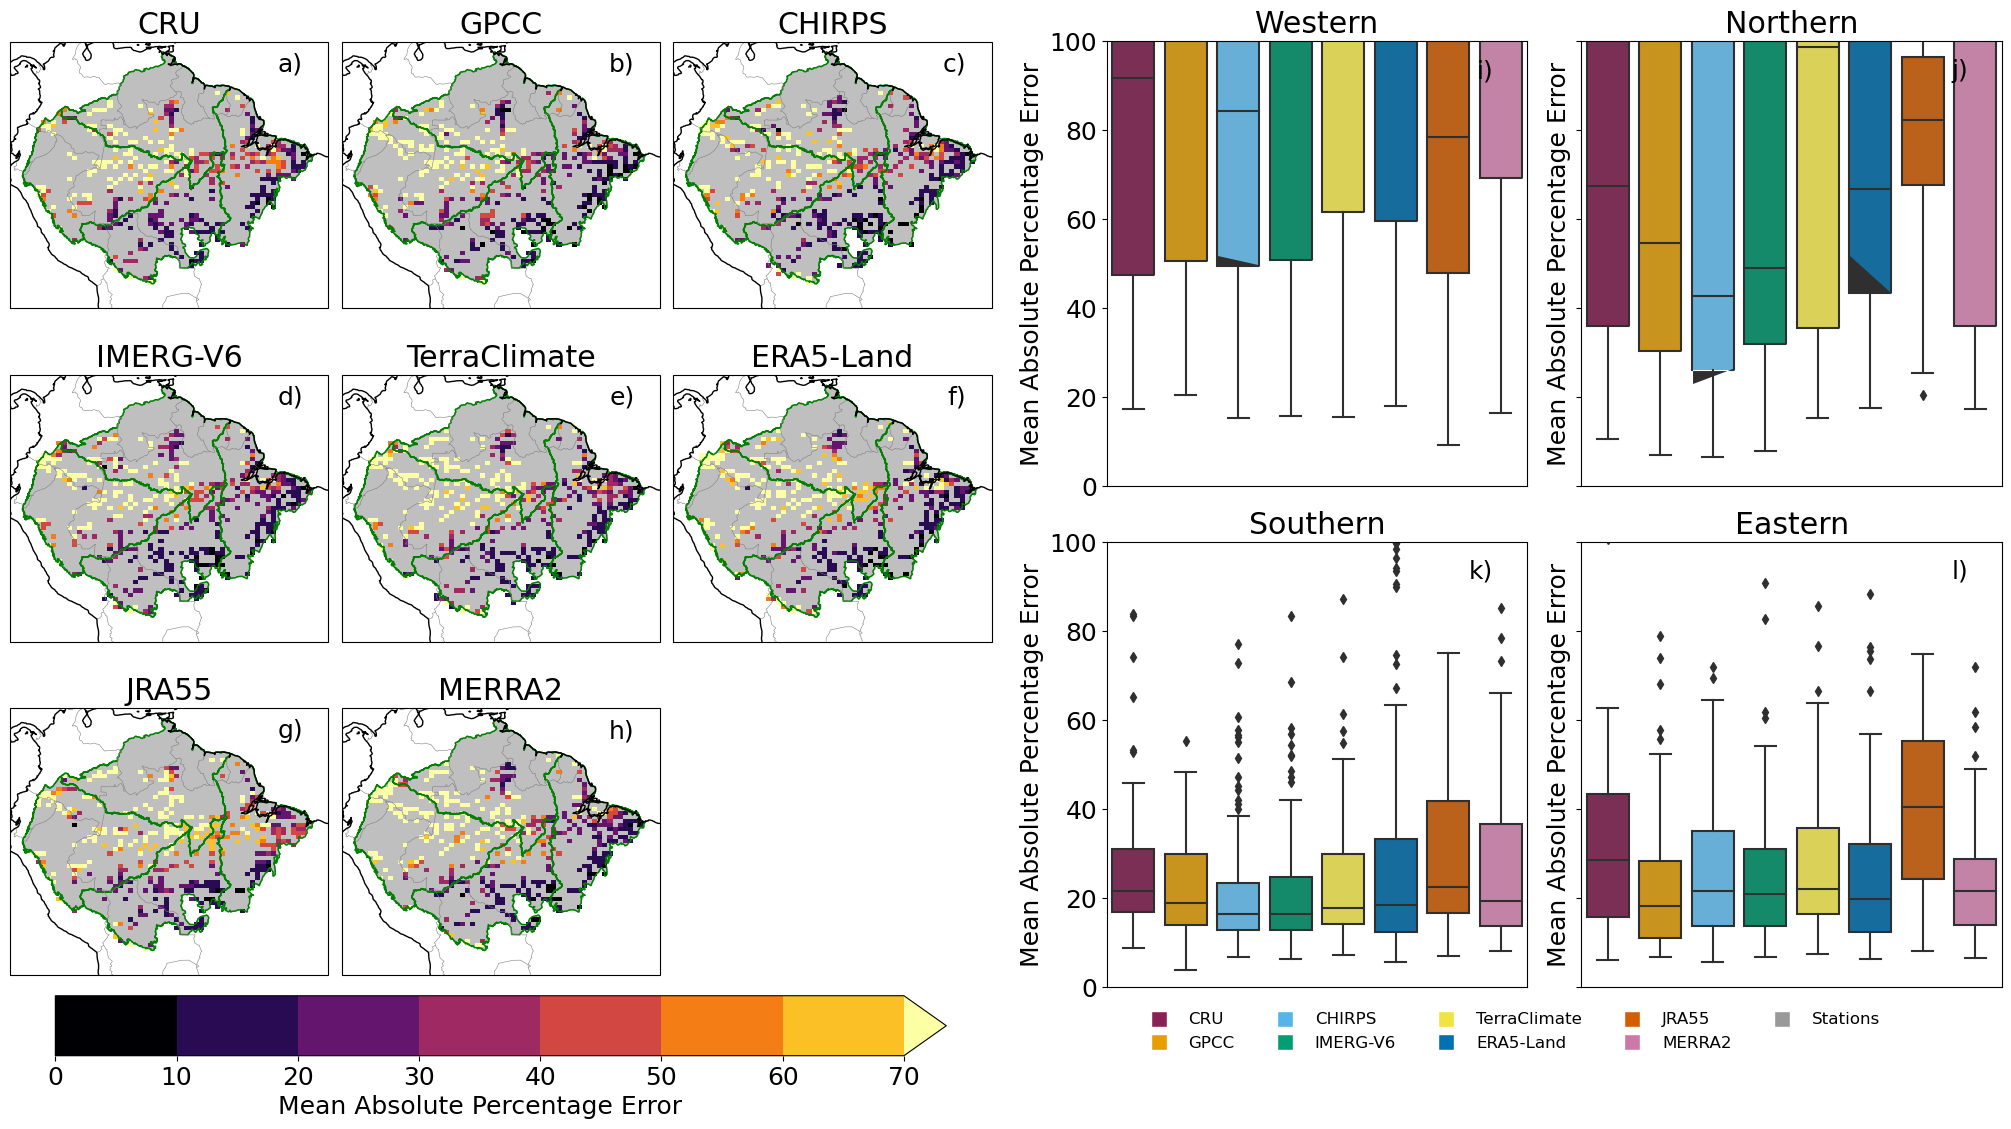

In [9]:
vmin = 0
vmax = 70
levels = 8
cmap =  mpl.cm.inferno
extend_cbar = 'max'
var = 'mape'
var_stat = 'Total'
label_cbar = 'Mean Absolute Percentage Error'
letters_22_eva = ['i)','j)', 'k)', 'l)']
fig = plt.figure(layout='constrained', figsize=(20, 10))
subfigs = fig.subfigures(1, 2)
axs_right = subfigs[1].subplots(2, 2, sharex=True, sharey=True)
axs_right = axs_right.flatten()
for i, region in enumerate(regions_list):
    #boxplot of df_metrics
    sns.boxplot( y=var, data=df_metrics[df_metrics.Region==region], ax=axs_right[i], hue_order=hue_order, palette=wong, hue='Dataset',x='Dataset',dodge=False).get_legend().remove()
    axs_right[i].set_title(region)
    axs_right[i].set_xlabel('')
    axs_right[i].tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) 
    axs_right[i].set_ylabel(label_cbar)
    axs_right[i].set_ylim([vmin, 100])
    axs_right[i].text(0.92,0.96,  letters_22_eva[i], transform=axs_right[i].transAxes,  fontsize=18, va='top', ha='right')
#create legend in the bottom center of the figure
subfigs[1].legend(handles=legend_elements, bbox_to_anchor=(0.5, -0.06), loc='lower center', ncol=5, frameon=False, fontsize=12)
plot_datasets33_nostat(subfigs[0], datasets_names, metrics_dict_05,  regions, vmin, vmax, levels, cmap, extend_cbar, var, var_stat, label_cbar)


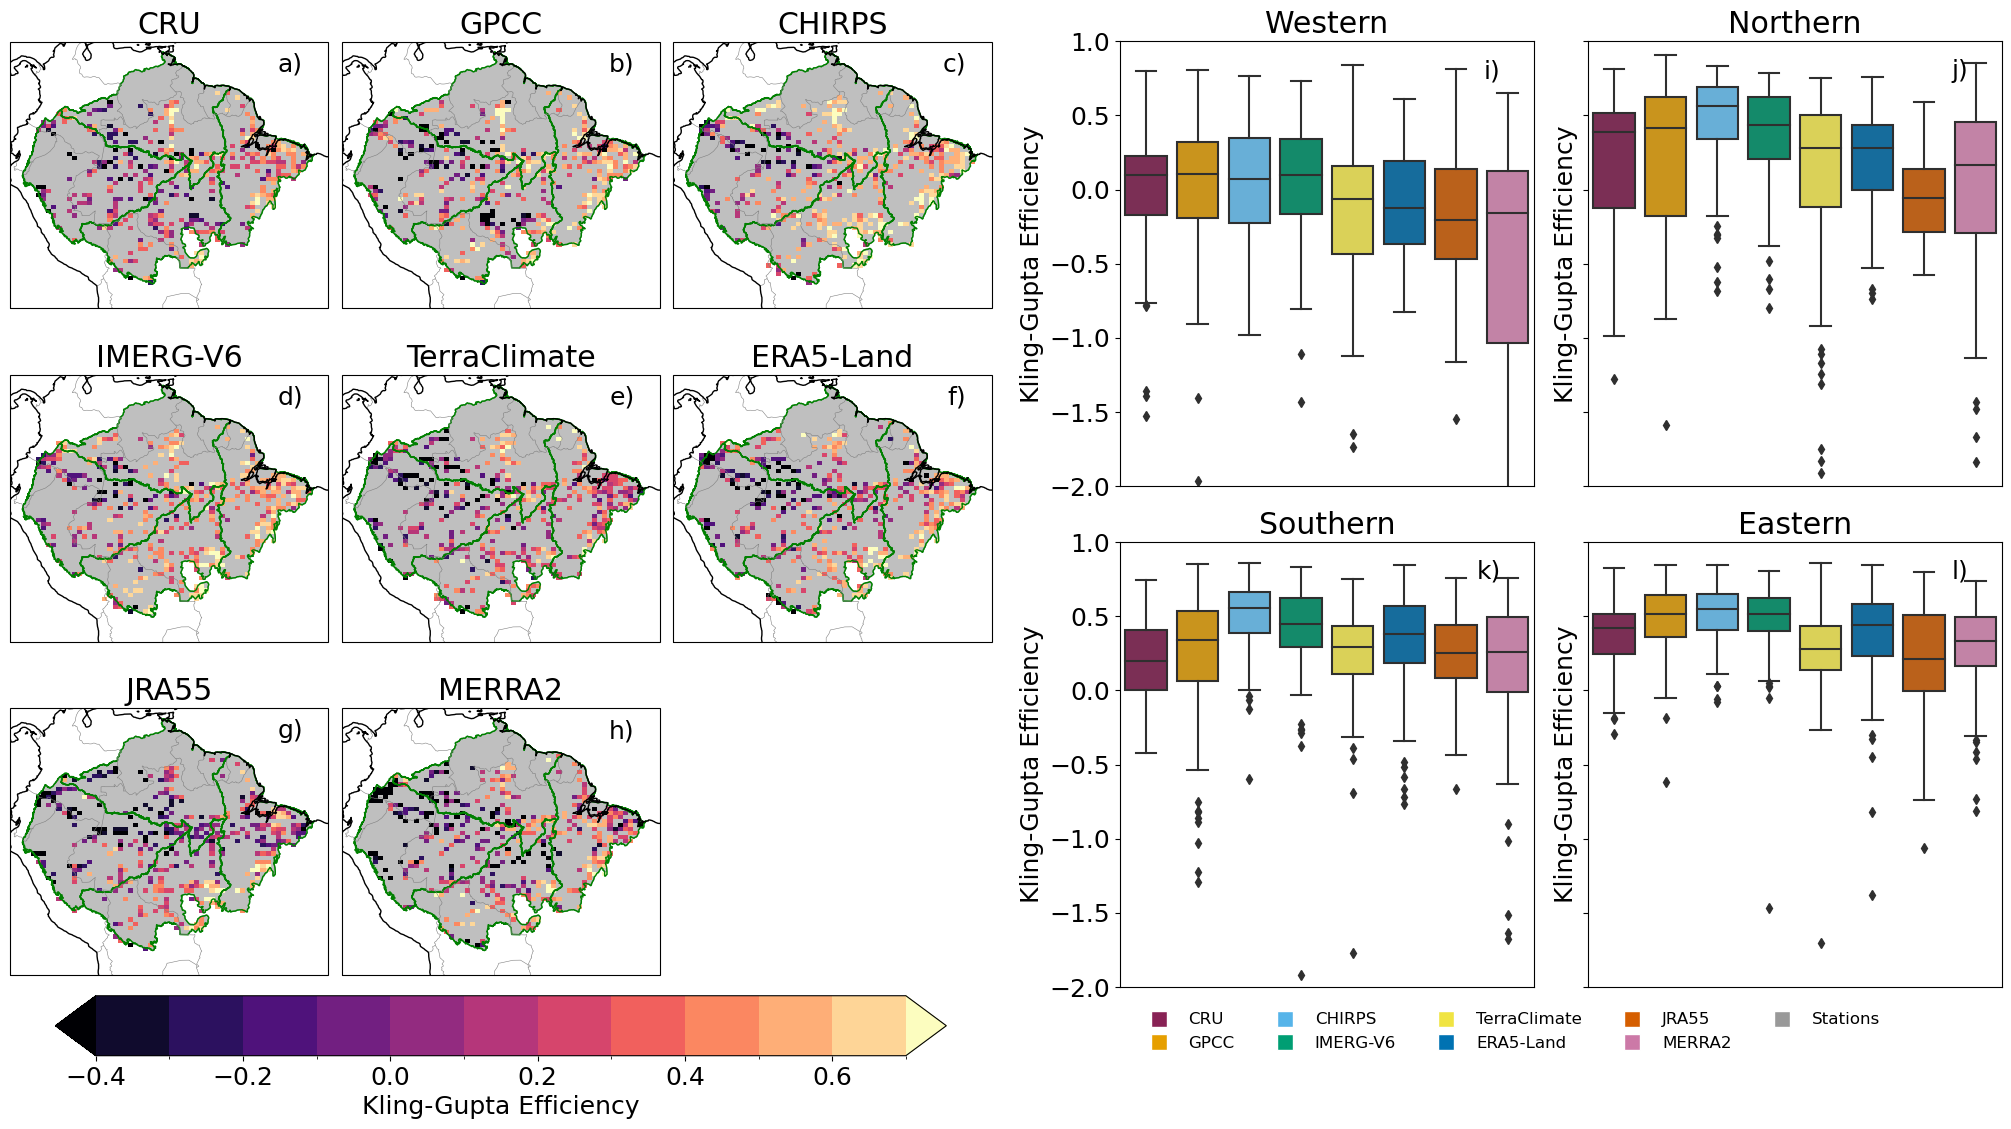

In [10]:
vmin = -0.4
vmax = 0.7
levels = 12
cmap =  mpl.cm.magma
extend_cbar = 'both'
var = 'kge'
var_stat = 'kge'
label_cbar = 'Kling-Gupta Efficiency'
fig = plt.figure(layout='constrained', figsize=(20, 10))
subfigs = fig.subfigures(1, 2)
axs_right = subfigs[1].subplots(2, 2, sharex=True, sharey=True)
axs_right = axs_right.flatten()
for i, region in enumerate(regions_list):
    #boxplot of df_metrics
    sns.boxplot( y=var, data=df_metrics[df_metrics.Region==region], ax=axs_right[i], hue_order=hue_order, palette=wong, hue='Dataset',x='Dataset',dodge=False).get_legend().remove()
    axs_right[i].set_title(region)
    axs_right[i].set_xlabel('')
    axs_right[i].tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) 
    axs_right[i].set_ylabel(label_cbar)
    axs_right[i].set_ylim([-2, 1])
    axs_right[i].text(0.92,0.96,  letters_22_eva[i], transform=axs_right[i].transAxes,  fontsize=18, va='top', ha='right')
    
#create legend in the bottom center of the figure
subfigs[1].legend(handles=legend_elements, bbox_to_anchor=(0.5, -0.06), loc='lower center', ncol=5, frameon=False, fontsize=12)
plot_datasets33_nostat(subfigs[0], datasets_names, metrics_dict_05,  regions, vmin, vmax, levels, cmap, extend_cbar, var, var_stat, label_cbar)


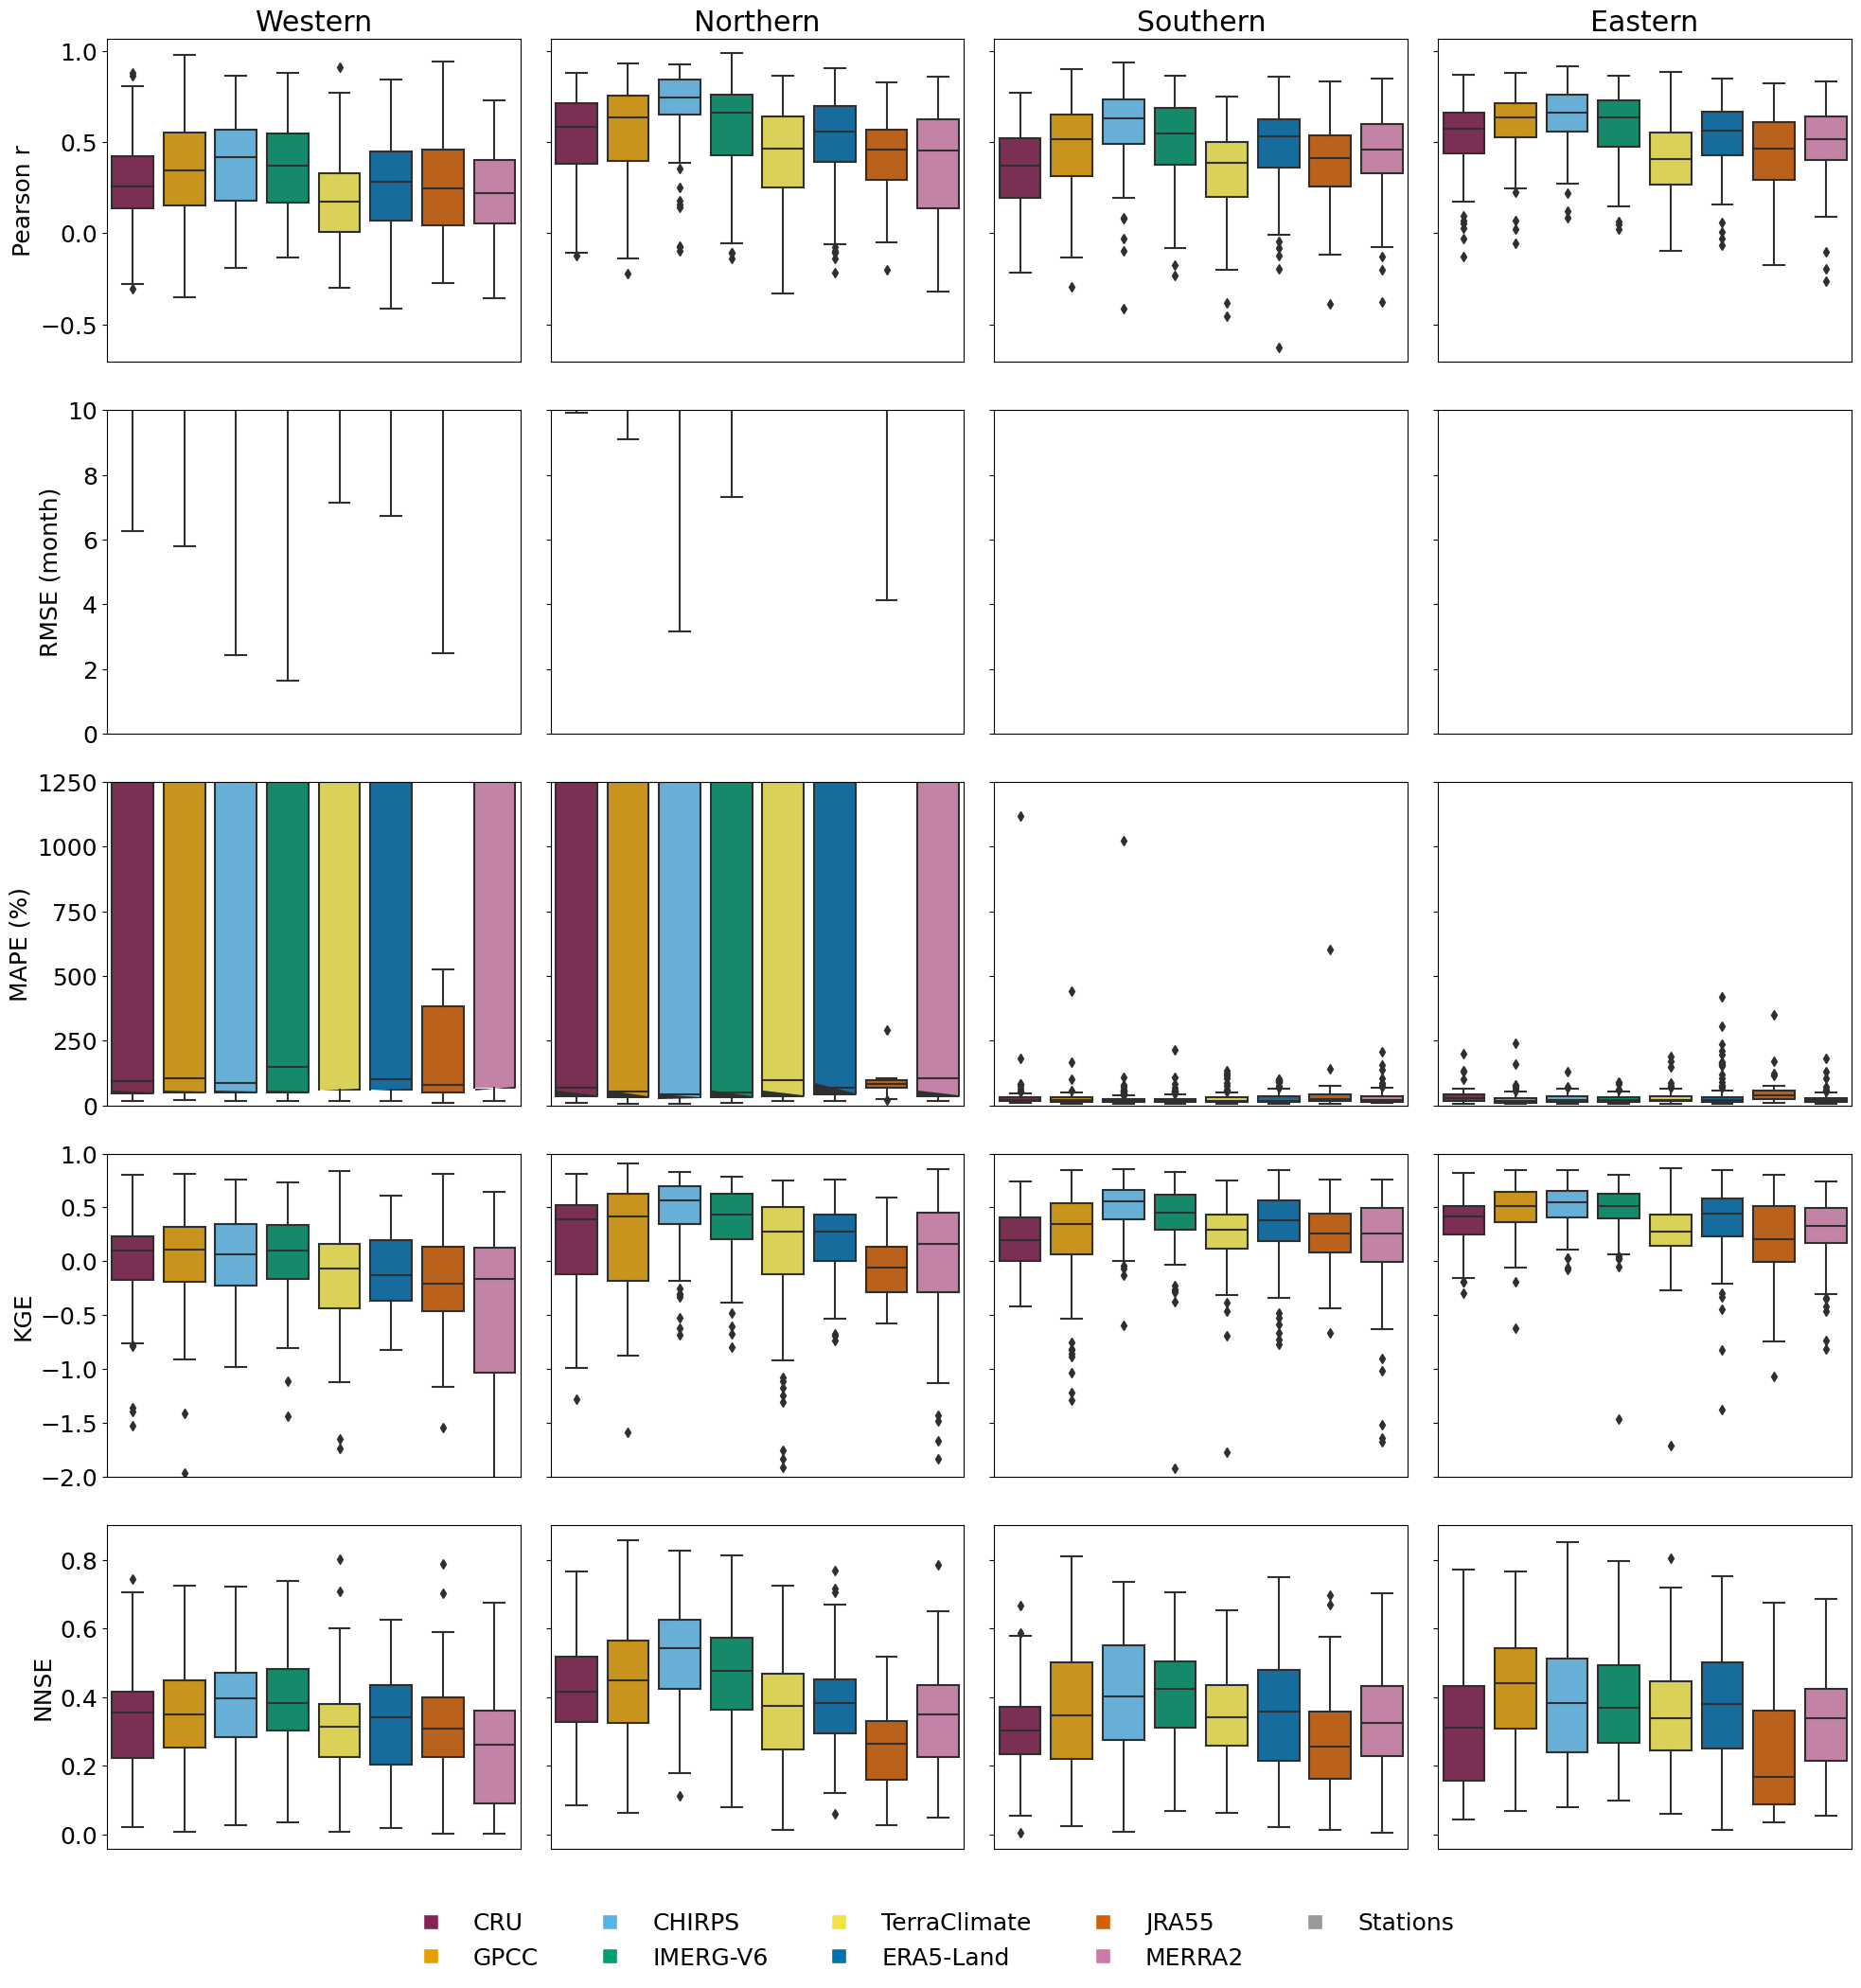

In [11]:
df_metrics['nnse'] = 1/(2-df_metrics['nse'])
metrics_plot = ['corr','rmse', 'mape', 'kge','nnse']
metrics_label = ['Pearson r', 'RMSE (month)', 'MAPE (%)', 'KGE', 'NNSE']

fig, axes = plt.subplots(len(metrics_plot), 4, figsize = (20, 20), sharey='row')
for i, metric in enumerate(metrics_plot):
    for j, region in enumerate(regions_list):
        #box plot
        df_region = df_metrics[df_metrics.Region == region]
        sns.boxplot( y=metric, data=df_region, ax=axes[i,j], hue_order=hue_order, palette=wong, hue='Dataset',x='Dataset',dodge=False).get_legend().remove()
        #axes[i,j].set_title(region)
        axes[i,j].set_xlabel('')
        axes[i,j].tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False)
        if j == 0:
            axes[i,j].set_ylabel(metrics_label[i])
        else:
            axes[i,j].set_ylabel('')
        if i == 0:
            axes[i,j].set_title(region)

axes[1,0].set_ylim(0,10)
axes[2,0].set_ylim(0,1250)
axes[3,0].set_ylim(-2,1)
fig.legend(handles=legend_elements, bbox_to_anchor=(0.5, -0.06), loc='lower center', ncol=5, frameon=False, fontsize=18)

plt.tight_layout()